# **Homework 2 - Machine Learning A.Y. 2023-2024**

Prof. Luca Iocchi

MSc in Artificial Intelligence and Robotics

La Sapienza, University of Rome

## Author

Ilaria De Sio - [desio.2064970@studenti.uniroma1.it](mailto:desio.2064970@studenti.uniroma1.it)

# 1) Data Loading

## 1.1) Import needed libraries

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime

from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, MaxPool2D, Input,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.optimizers.legacy import Adam
from keras.models import load_model

In [ ]:
# To use the GPU units
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

## 1.2) Load data (locally)

In [2]:
trainingset = "train"
testset = "test"

batch_size = 128

# Add Data Augmentation to the training set 
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range=10,       
    width_shift_range=0.1,   
    height_shift_range=0.1, 
    shear_range=0.2,         
    zoom_range=0.1,         
    horizontal_flip=False,    
    fill_mode='nearest',
    validation_split=0.2     
)

train_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=True,
    subset='training'
)

# Generator of images used during the training step to compute the validation loss and accuracy
validation_generator = train_datagen.flow_from_directory(
    directory=trainingset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,  # No need to shuffle for validation
    subset='validation'  # Specify that this is the validation subset
)

# withouts edits
test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

test_generator = test_datagen.flow_from_directory(
    directory=testset,
    target_size=(96, 96),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

num_samples = train_generator.n
num_classes = train_generator.num_classes
input_shape = train_generator.image_shape

classnames = [k for k,v in train_generator.class_indices.items()]

print("Image input %s" %str(input_shape))
print("Classes: %r" %classnames)

print('Loaded %d training samples from %d classes.' %(num_samples,num_classes))
print('Loaded %d test samples from %d classes.' %(test_generator.n,test_generator.num_classes))

Found 5096 images belonging to 5 classes.
Found 1273 images belonging to 5 classes.
Found 2749 images belonging to 5 classes.
Image input (96, 96, 3)
Classes: ['0', '1', '2', '3', '4']
Loaded 5096 training samples from 5 classes.
Loaded 2749 test samples from 5 classes.


## 1.3) Data Analysis

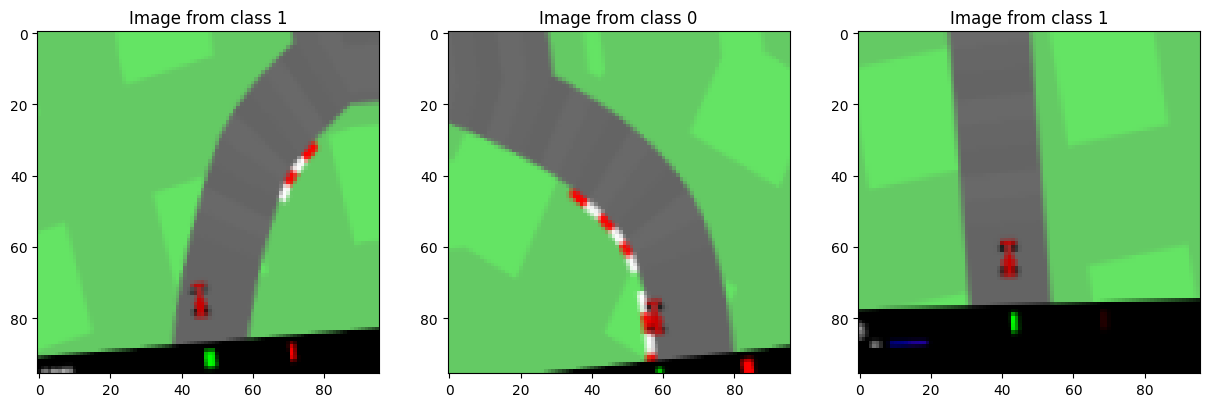

In [3]:
n = 3  
a, b = train_generator.next()

fig, axs = plt.subplots(1, n, figsize=(15, 5))  # 1 row, n col

for i in range(0, n):
    image = a[i]
    label = b[i].argmax()  # categorical from one-hot-encoding
    axs[i].set_title("Image from class {}".format(classnames[label]))
    axs[i].imshow(image)

plt.show()

In [4]:
def plot_class_distribution(dataset_path, dataset_type):
    # counts samples in classes
    class_counts = {class_name.split('/')[-1]: len(files)
                    for class_name, _, files in os.walk(dataset_path)
                    if not class_name == dataset_path}
    
    # Order
    class_counts = dict(sorted(class_counts.items()))

    if dataset_type == 'Training':
        palette = sns.color_palette("viridis", len(class_counts))
    else:
        palette = sns.color_palette("plasma", len(class_counts))

    plt.figure(figsize=(10, 6))
    
    for i, (class_name, count) in enumerate(class_counts.items()):
        plt.bar(class_name, count, color=palette[i])

    plt.xlabel('Action (Classes)')
    plt.ylabel('Number of samples')
    plt.title(f'Distribution for {dataset_type} Set')
    plt.xticks(list(class_counts.keys()))

    plt.show()


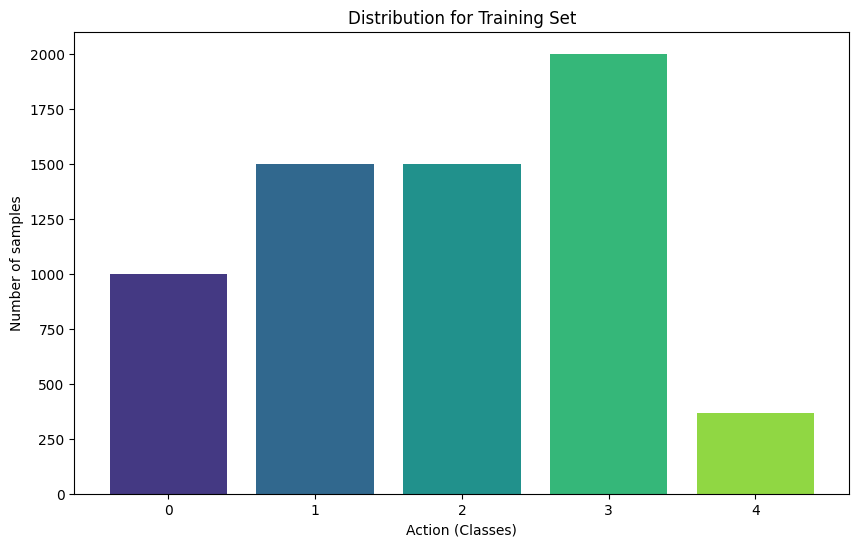

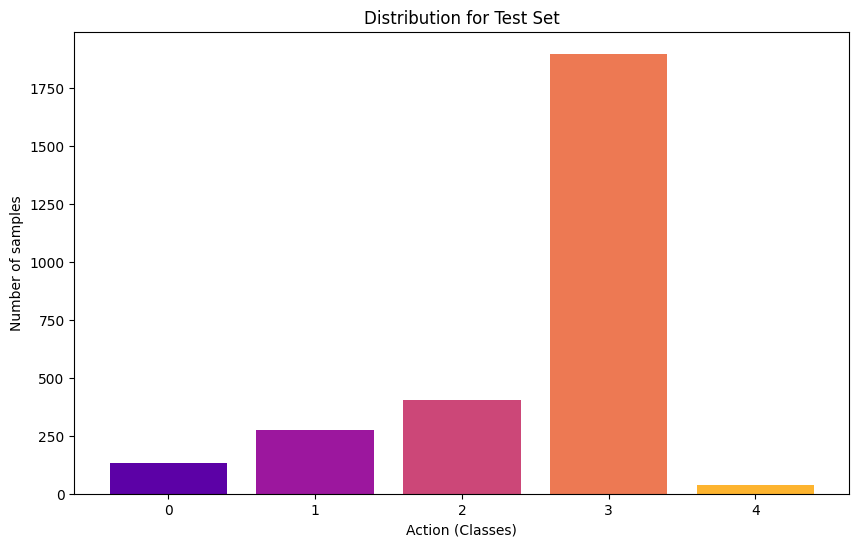

In [5]:
# plot for training set
plot_class_distribution(trainingset, 'Training')

# plot for test set
plot_class_distribution(testset, 'Test')

# 2) Model Design

## 2.1) First approach

In [ ]:
def CNN1(input_shape, num_classes, base_width=16, depth=2, dropout_rate=0.4, kernel_size=3, l2_reg=None, optimizer='adam'):
    model = Sequential()
    filters = base_width

    for i in range(depth):
        if l2_reg is not None:
            kernel_regularizer = regularizers.l2(l2_reg)
        else:
            kernel_regularizer = None

        if i == 0:
            # only the first layer Conv2D receive the input_shape
            model.add(Conv2D(filters=filters,
                             kernel_size=kernel_size,
                             activation="relu",
                             strides=1,
                             padding="same",
                             kernel_regularizer=kernel_regularizer,
                             input_shape=input_shape))
        else:
            model.add(Conv2D(filters=filters,
                             kernel_size=kernel_size,
                             activation="relu",
                             strides=1,
                             padding="same",
                             kernel_regularizer=kernel_regularizer))

        model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding="valid"))
        filters *= 2

    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation="softmax"))

    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# model creation
model = CNN1(input_shape=(96, 96, 3), num_classes=5, base_width=64, depth=2, dropout_rate=0.4, kernel_size=3, l2_reg=0.001, optimizer='adam')
model.summary()

created_by = 'CNN1'
history=None

## 2.1) Second approach

In [6]:
def CNN2(input_shape, num_classes, base_width=64, depth=2, kernel_size=3, l2_reg=None, optimizer='sgd', lr=0.001):
    model = Sequential()
    
    for i in range(depth):
        # Regolator L2 
        if l2_reg is not None:
            kernel_regularizer = tf.keras.regularizers.l2(l2_reg)
        else:
            kernel_regularizer = None

        # filters used: 
        filters = base_width * (2 ** i)

        # Add levels Conv2D, Batch Normalization and MaxPooling2D
        # input_shape only first layer
        if i == 0:
            model.add(Conv2D(filters=filters, 
                             kernel_size=kernel_size, 
                             strides=(1, 1), 
                             padding='valid', 
                             kernel_regularizer=kernel_regularizer,
                             input_shape=input_shape))
        else:
            model.add(Conv2D(filters=filters, 
                             kernel_size=kernel_size, 
                             strides=(1, 1), 
                             padding='valid', 
                             kernel_regularizer=kernel_regularizer))

        model.add(BatchNormalization())  
        model.add(tf.keras.layers.Activation('relu'))  # Explicit use of Activation for consistency
        model.add(MaxPooling2D(pool_size=(3, 3), padding='valid'))

    # Aggiunta di Flatten e Dense
    model.add(Flatten())
    model.add(Dense(48, activation='relu')) # Size of the last hidden layer before the output layer.
    model.add(Dense(num_classes, activation='softmax'))
    
    # optimizer chosen
    if optimizer.lower() == 'adam':
        optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
    elif optimizer.lower() == 'sgd':
        optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
    
    # Compilare il modello
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# model creation
model = CNN2(input_shape=(96, 96, 3), num_classes=5, base_width=64, depth=3, kernel_size=3, l2_reg=None, optimizer='sgd', lr=0.001)
model.summary()

created_by = 'CNN2'
history=None

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 94, 94, 64)        1792      
                                                                 
 batch_normalization (Batch  (None, 94, 94, 64)        256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 94, 94, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 29, 29, 128)       5

## 2.1) Training

In [7]:
epochs=50
steps_per_epoch=train_generator.n//train_generator.batch_size
val_steps=validation_generator.n//validation_generator.batch_size+1
try:
    h = model.fit(            
        train_generator,
        epochs=epochs, 
        verbose=1,
        steps_per_epoch=steps_per_epoch,
        validation_data=validation_generator,
        validation_steps=val_steps
    )

except KeyboardInterrupt:
    pass
if history is None:
    history = h.history
else:
    history['loss'].extend(h.history['loss'])
    history['accuracy'].extend(h.history['accuracy'])
    history['val_loss'].extend(h.history['val_loss'])
    history['val_accuracy'].extend(h.history['val_accuracy'])


Epoch 1/50
39/39 [==============================] - 49s 1s/step - loss: 1.5365 - accuracy: 0.3971 - val_loss: 1.5927 - val_accuracy: 0.2357
Epoch 2/50
39/39 [==============================] - 47s 1s/step - loss: 1.3464 - accuracy: 0.4827 - val_loss: 1.6054 - val_accuracy: 0.2357
Epoch 3/50
39/39 [==============================] - 48s 1s/step - loss: 1.3045 - accuracy: 0.4958 - val_loss: 1.6281 - val_accuracy: 0.2357
Epoch 4/50
39/39 [==============================] - 42s 1s/step - loss: 1.2864 - accuracy: 0.5030 - val_loss: 1.6505 - val_accuracy: 0.2357
Epoch 5/50
39/39 [==============================] - 42s 1s/step - loss: 1.2650 - accuracy: 0.5141 - val_loss: 1.6555 - val_accuracy: 0.2357
Epoch 6/50
39/39 [==============================] - 45s 1s/step - loss: 1.2499 - accuracy: 0.5193 - val_loss: 1.6507 - val_accuracy: 0.2357
Epoch 7/50
39/39 [==============================] - 48s 1s/step - loss: 1.2491 - accuracy: 0.5244 - val_loss: 1.6420 - val_accuracy: 0.2357
Epoch 8/50
39/39 [==

In [9]:
test_steps = len(test_generator)
pred = model.predict(test_generator,verbose=1,steps=test_steps)

Ypred = np.argmax(pred, axis=1)
print(Ypred)

Ytest = test_generator.classes

22/22 [==============================] - 7s 322ms/step
[3 3 3 ... 2 2 0]


In [10]:
loss, accuracy = model.evaluate(test_generator,verbose=1,steps=test_steps)
print('Test loss: %f' %loss)
print('Test accuracy: %f' %accuracy)

22/22 [==============================] - 7s 295ms/step - loss: 0.9937 - accuracy: 0.6344
Test loss: 0.993697
Test accuracy: 0.634413


## 2.2) Evaluation and Graph Results

In [ ]:
#Plot for the loss
plt.figure(figsize=(10, 6)) 
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

#Plot for the accuracy
plt.figure(figsize=(10, 6)) 
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

In [11]:
print(classification_report(Ytest, Ypred, labels=None, target_names=classnames, digits=3))

              precision    recall  f1-score   support

           0      0.293     0.203     0.240       133
           1      0.340     0.487     0.401       275
           2      0.409     0.736     0.526       406
           3      0.840     0.677     0.750      1896
           4      0.000     0.000     0.000        39

    accuracy                          0.634      2749
   macro avg      0.376     0.421     0.383      2749
weighted avg      0.688     0.634     0.646      2749



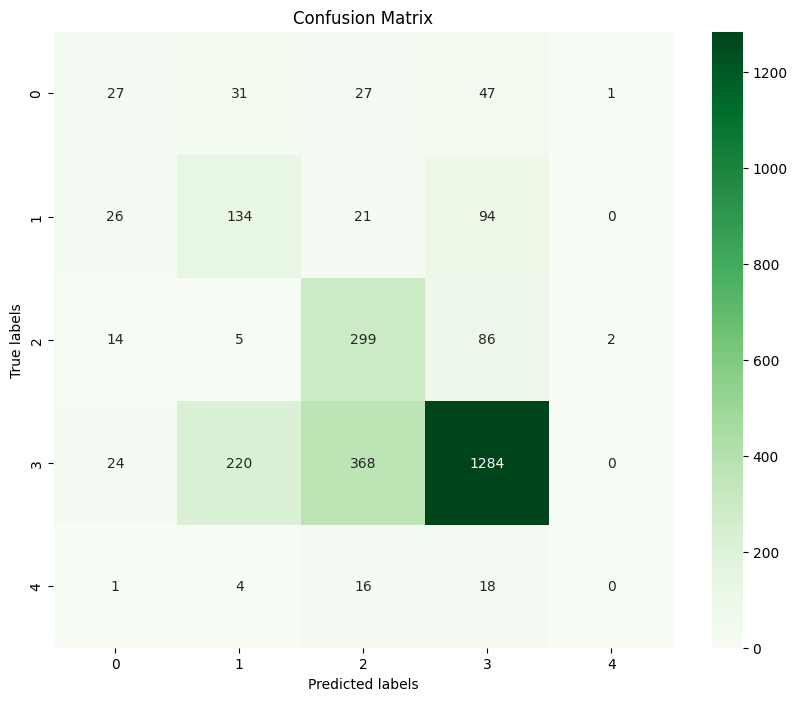

In [12]:
if created_by == 'CNN1':  cmcolor = "Blues"
else: cmcolor = "Greens"

conf_matrix = confusion_matrix(Ytest, Ypred)

# heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap=cmcolor, xticklabels=classnames, yticklabels=classnames)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 2.3)Optimization

# 3) Save the Model

In [ ]:
if created_by == 'CNN1':
    model.save('firstmodel.keras')
else:
    model.save('secondmodel.keras')